## 04 - Neural Networks with keras

In this notebook we implement an approach based on neural networks, using the library **keras** from **tensorflow** to predict whether the tweets refer to a real disaster or not.

#### Loading data

We start by importing the packages we are going to use and loading the datasets:

In [285]:
import math

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras

from keras.layers import TextVectorization
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Dense

from sklearn.model_selection import KFold

import time

train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

train_data['text'].replace('http:\/\/\S*', 'urltoken', regex=True, inplace=True)
test_data['text'].replace('http:\/\/\S*', 'urltoken', regex=True, inplace=True)

train_text, train_label = np.array(train_data['text']), np.array(train_data['target'])
test_text = test_data['text']

print(train_text.shape)
print(train_label.shape)
print(test_text.shape)

(7613,)
(7613,)
(3263,)


In [286]:
# Word counts
pd.Series(np.array([len(text.split()) for text in train_text])).describe()

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
dtype: float64

In [287]:
# Number of unique tokens among all tweets
len(np.unique(np.array(' '.join(train_text).split())))

27736

In [288]:
def build_model(params):
    dropout_rate = 0.5

    # Inputs are text strings, then we vectorize them
    inputs = keras.Input(shape=(1,), dtype=tf.string, name='text')

    vectorizer = TextVectorization(
        standardize='lower_and_strip_punctuation',
        max_tokens=params['max_features'],
        output_mode="int",
        output_sequence_length=params['sequence_length'],
    )
    vectorizer.adapt(train_text)
    x = vectorizer(inputs)

    # We use Embedding to map the vectorized text onto a space of dimension embedding_dim
    x = Embedding(params['max_features'] + 1, params['embedding_dim'])(x)
    x = Dropout(dropout_rate)(x)

    # Conv1D + GlobalMaxPooling
    x = Conv1D(params['conv_1_filters'], params['conv_1_kernel_size'], strides=params['conv_1_strides'], activation='relu')(x)
    x = Conv1D(params['conv_2_filters'], params['conv_2_kernel_size'], strides=params['conv_2_strides'], activation='relu')(x)
    x = GlobalMaxPooling1D()(x)

    # Dense hidden layer
    x = Dense(params['dense_layer_size'], activation="relu")(x)
    x = Dropout(dropout_rate)(x)

    # Output layer
    outputs = Dense(1, activation="sigmoid", name="predictions")(x)

    model = keras.Model(inputs, outputs)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])

    return model

In [289]:
# Initial params
params = {
    'max_features': 10000,
    'sequence_length': 32,
    'embedding_dim': 32,
    'conv_1_filters': 32,
    'conv_1_kernel_size': 3,
    'conv_1_strides': 1,
    'conv_2_filters': 32,
    'conv_2_kernel_size': 3,
    'conv_2_strides': 1,
    'dense_layer_size': 32
}

In [291]:
def train(model, epochs, kfold):
    start = time.time()

    scores = []
    for fold_train_indices, fold_val_indices in kfold.split(train_text, train_label):
        fold_train_text = train_text[fold_train_indices]
        fold_train_label = train_label[fold_train_indices]
        fold_val_text = train_text[fold_val_indices]
        fold_val_label = train_label[fold_val_indices]

        model.fit(fold_train_text, fold_train_label, epochs=epochs, verbose=0)
        fold_val_score = model.evaluate(fold_val_text, fold_val_label)
        scores.append(fold_val_score)

    print(">>> Training time: ", time.time() - start, "s")

    return np.mean(scores)

In [292]:
def mutate(genotype):
    for param in params.keys():
        # Random number r = 1 + |N(0, 0.5)|, we ensure r >= 1 and typically r < 2
        r = 1 + np.abs(np.random.normal(0, 0.5))
        # We decide at random with equal probability whether we take r or 1/r
        perturbed_value = round(np.random.choice([genotype[param] * r, genotype[param] / r]))
        genotype[param] = np.max([1, perturbed_value]).item()

    # Fix unfeasible genotypes
    input_size_conv_1 = genotype['sequence_length']
    if genotype['conv_1_kernel_size'] > input_size_conv_1:
        genotype['conv_1_kernel_size'] = input_size_conv_1

    input_size_conv_2 = math.floor((input_size_conv_1 - (genotype['conv_1_kernel_size'] - genotype['conv_1_strides'])) / genotype['conv_1_strides'])
    if genotype['conv_2_kernel_size'] > input_size_conv_2:
        genotype['conv_2_kernel_size'] = input_size_conv_2

    return genotype

In [293]:
def reproduce(genotype_1, genotype_2):
    genotype = {}
    for param in params.keys():
        genotype[param] = round(np.mean([genotype_1[param], genotype_2[param]]))

    return mutate(genotype)

In [ ]:
def print_genotype(genotype):
    str = genotype['max_features'] + ' '
    str += genotype['sequence_length'] + ' '
    str += genotype['embedding_dim'] + ' '
    str += genotype['conv_1_filters'] + '-' + genotype['conv_1_kernel_size'] + '-' + genotype['conv_1_strides'] + ' '
    str += genotype['conv_2_filters'] + '-' + genotype['conv_2_kernel_size'] + '-' + genotype['conv_2_strides'] + ' '
    str += genotype['dense_layer_size']
    print(str)

In [294]:
def generation(population):
    n = len(population)
    probabilities = np.linspace(1.8, 0.2, n) / n

    children = []
    for i in range(n):
        parents = np.random.choice(population, p=probabilities, size=2, replace=False)
        child = reproduce(parents[0], parents[1])
        children.append(child)

    population = children

    epochs = 3
    kfold = KFold(n_splits=3, shuffle=True)

    scores = []
    for genotype in population:
        print("> Model", len(scores), end="")
        print_genotype(genotype)
        try:
            model = build_model(genotype)
            score = train(model, epochs, kfold)
        except:
            score = 0
        scores.append(score)

    sorted_tuples = sorted(zip(scores, population), reverse=True)
    return {
        'population': [genotype for _, genotype in sorted_tuples],
        'scores': [score for score, _ in sorted_tuples]
    }

In [295]:
n_generations = 10
population_size = 20

population = [params] * population_size

start = time.time()

generation_scores = []
for i in range(n_generations):
    print("Generation", i)
    generation_results = generation(population)
    population = generation_results['population']
    scores = generation_results['scores']
    generation_scores.append(scores)


print("Total time:", round(time.time() - start, 2), "s")

Generation 0
> Model 0
80/80 [==============================] - 0s 4ms/step - loss: 0.1383 - accuracy: 0.9574 - precision_313: 0.9487 - recall_313: 0.9539
>>> Training time:  28.15664529800415 s
> Model 1
80/80 [==============================

In [296]:
population

[{'max_features': 43644,
  'sequence_length': 104,
  'embedding_dim': 193,
  'conv_1_filters': 89,
  'conv_1_kernel_size': 18,
  'conv_1_strides': 2,
  'conv_2_filters': 25,
  'conv_2_kernel_size': 4,
  'conv_2_strides': 3,
  'dense_layer_size': 64},
 {'max_features': 82733,
  'sequence_length': 70,
  'embedding_dim': 83,
  'conv_1_filters': 22,
  'conv_1_kernel_size': 31,
  'conv_1_strides': 5,
  'conv_2_filters': 90,
  'conv_2_kernel_size': 2,
  'conv_2_strides': 11,
  'dense_layer_size': 111},
 {'max_features': 74651,
  'sequence_length': 50,
  'embedding_dim': 66,
  'conv_1_filters': 38,
  'conv_1_kernel_size': 20,
  'conv_1_strides': 7,
  'conv_2_filters': 51,
  'conv_2_kernel_size': 5,
  'conv_2_strides': 8,
  'dense_layer_size': 72},
 {'max_features': 24445,
  'sequence_length': 53,
  'embedding_dim': 151,
  'conv_1_filters': 88,
  'conv_1_kernel_size': 3,
  'conv_1_strides': 2,
  'conv_2_filters': 42,
  'conv_2_kernel_size': 5,
  'conv_2_strides': 12,
  'dense_layer_size': 36},

In [297]:
for param in params.keys():
    print(param, round(np.mean([genotype[param] for genotype in population])), "/", params[param])

max_features 69363 / 10000
sequence_length 63 / 32
embedding_dim 102 / 32
conv_1_filters 45 / 32
conv_1_kernel_size 15 / 3
conv_1_strides 3 / 1
conv_2_filters 53 / 32
conv_2_kernel_size 4 / 3
conv_2_strides 8 / 1
dense_layer_size 74 / 32


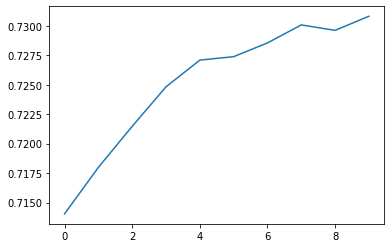

In [298]:
generation_scores

generation_average_scores = np.mean(generation_scores, axis=1)

import matplotlib.pyplot as plt
plt.plot(generation_average_scores)

In [302]:
best_genotype = population[0]
model = build_model(best_genotype)
model.fit(train_text, train_label, epochs=3, verbose=2)

model.evaluate(train_text, train_label, verbose=2)

Epoch 1/3
238/238 - 61s - loss: 0.6261 - accuracy: 0.6363 - precision_513: 0.6773 - recall_513: 0.2932
Epoch 2/3
238/238 - 59s - loss: 0.3797 - accuracy: 0.8441 - precision_513: 0.8633 - recall_513: 0.7570
Epoch 3/3
238/238 - 56s - loss: 0.1754 - accuracy: 0.9408 - precision_513: 0.9516 - recall_513: 0.9083
238/238 - 3s - loss: 0.0677 - accuracy: 0.9786 - precision_513: 0.9878 - recall_513: 0.9621


[0.06768204271793365,
 0.9785892367362976,
 0.9877589344978333,
 0.9620910882949829]

In [303]:
test_pred = model.predict(test_text)
test_pred = np.round(test_pred).flatten().astype('int')

test_pred

array([1, 0, 1, ..., 1, 1, 1])

We generate vector counts for both train and test data using scikit's **CountVectorizer**. In particular, notice that we fit the vectorizer only with the train tokens, and use it to transform both train and test data. If there are N unique tokens in the train dataset, for each tweet we obtain a vector of length N whose values are the word counts:

In [304]:
output = pd.DataFrame({'id': test_data['id'], 'target': test_pred})
output.to_csv('predictions/nnets.csv', index=False)
print("Submission successfully saved!")

Submission successfully saved!
